# Clustering and outliers detection

This notebooks uses the module clustering of goodforest_lib to make naive outlying detection.

The pipeline is the following:
1. Load the data
2. Cluster the data on a given period
    1. Using a graph approach
    2. Using a zone approach
3. Detect outliers on the next period

For further improvments, here are the next main steps:
- Parametrize the different parameters (thresholds, periods duration, channels to use, etc.)
- Evaulate the performance using accurate data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from goodforest_lib.visualization.visualize_clusters import (
    visualize_clusters,
    display_cluster_behavior,
)

## Fetch the data

Get the data from the tif image on an area of interest (aoi).


In [2]:
from goodforest_lib.models.clustering import fetch_data_with_dates

# Import all the available data for the area of interest
images, dates = fetch_data_with_dates("../test_client/aoi_0/31UCP", ["CR_SWIR"])
images.shape

(129, 25, 147, 291)

In [3]:
from goodforest_lib.visualization.visualize_tif import TifImageFromS2

# Import a cloudless background image
rgb_bkg = TifImageFromS2("../test_client/aoi_0/31UCP/2020-07-09.tif").get_rgb_array()

# Clustering with graph


In [4]:
from goodforest_lib.models.clustering.graph_segmentation.create_clusters import (
    get_clusters,
)

# Create a partition of the area of interest using a graph-based segmentation algorithm
partition_graph, dates_clustering = get_clusters(
    images,
    dates,
    resolution=1000,
    bands=[2, 4, 5, 6, 7, 8, 9, 10, 24],
    before_date="2022-08-01",
    cluster_period_duration_in_days=30 * 4,
)

Graph has 32467 nodes and 128727 edges
Partition has 4441 clusters, characterizing 32467 pixels
(147, 291)


(147, 291)


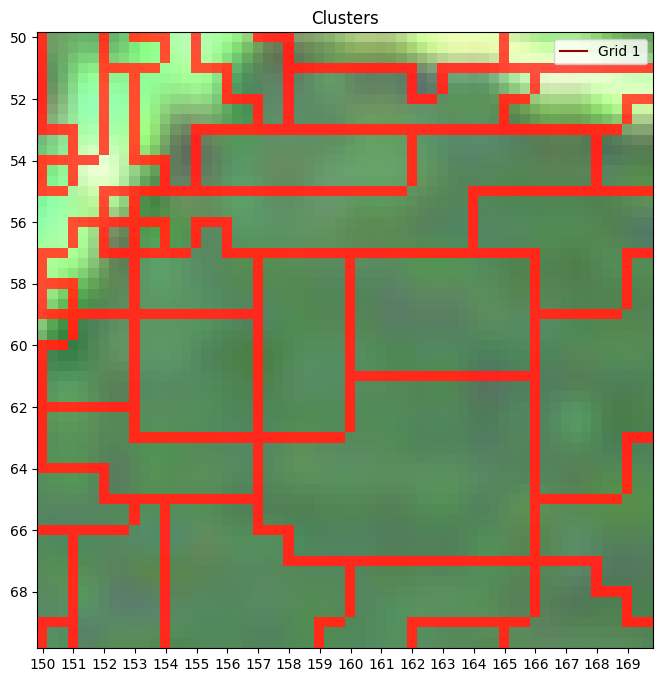

In [5]:
visualize_clusters(partition_graph, rgb_bkg, 3, (50, 150, 70, 170))

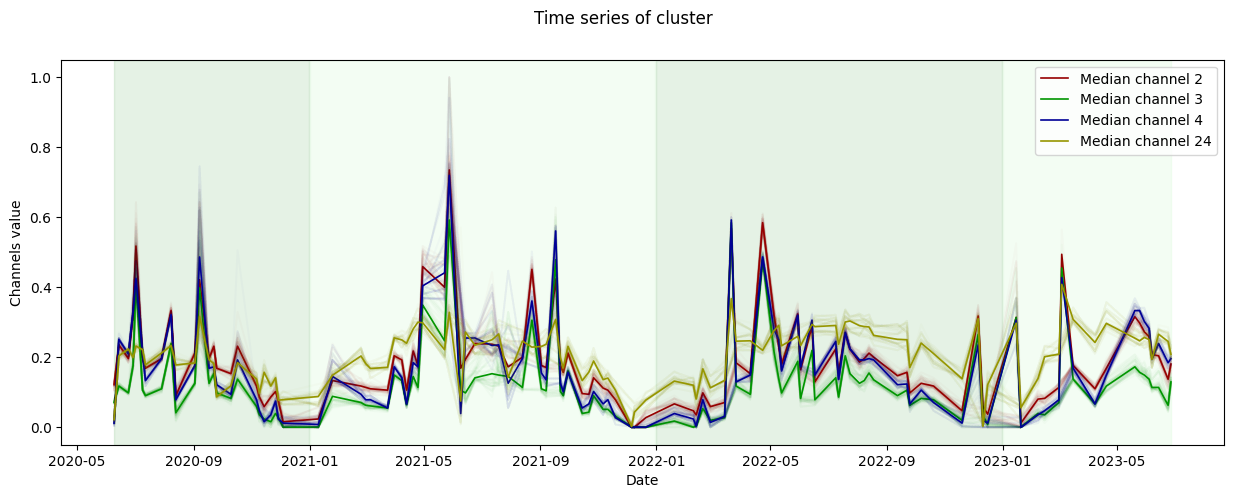

In [6]:
from goodforest_lib.models.clustering.fetch_data import get_historical_data_with_dates

historical_data, dates = get_historical_data_with_dates(images, dates, list(range(25)))
historical_data = historical_data.transpose(2, 3, 0, 1)
display_cluster_behavior(
    historical_data, dates, partition_graph, dates_clustering, (100, 245), [2, 3, 4, 24]
)

# Clustering with zones


In [7]:
from goodforest_lib.models.clustering.zone_segmentation.create_clusters import (
    get_clusters as get_clusters_zone,
)

# Create a partition of the area of interest using a graph-based segmentation algorithm
partition_zone, dates_clustering = get_clusters_zone(
    images,
    dates,
    bands=[24],
    before_date="2022-08-01",
    cluster_period_duration_in_days=30 * 4,
)

100%|██████████| 885/885 [00:10<00:00, 86.09it/s] 


(147, 291)
(147, 291)


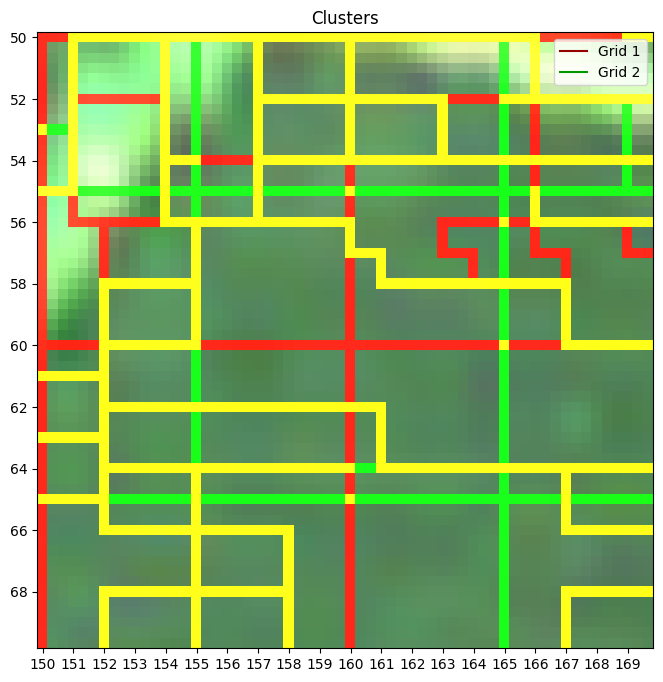

In [8]:
visualize_clusters(partition_zone, rgb_bkg, 3, (50, 150, 70, 170))

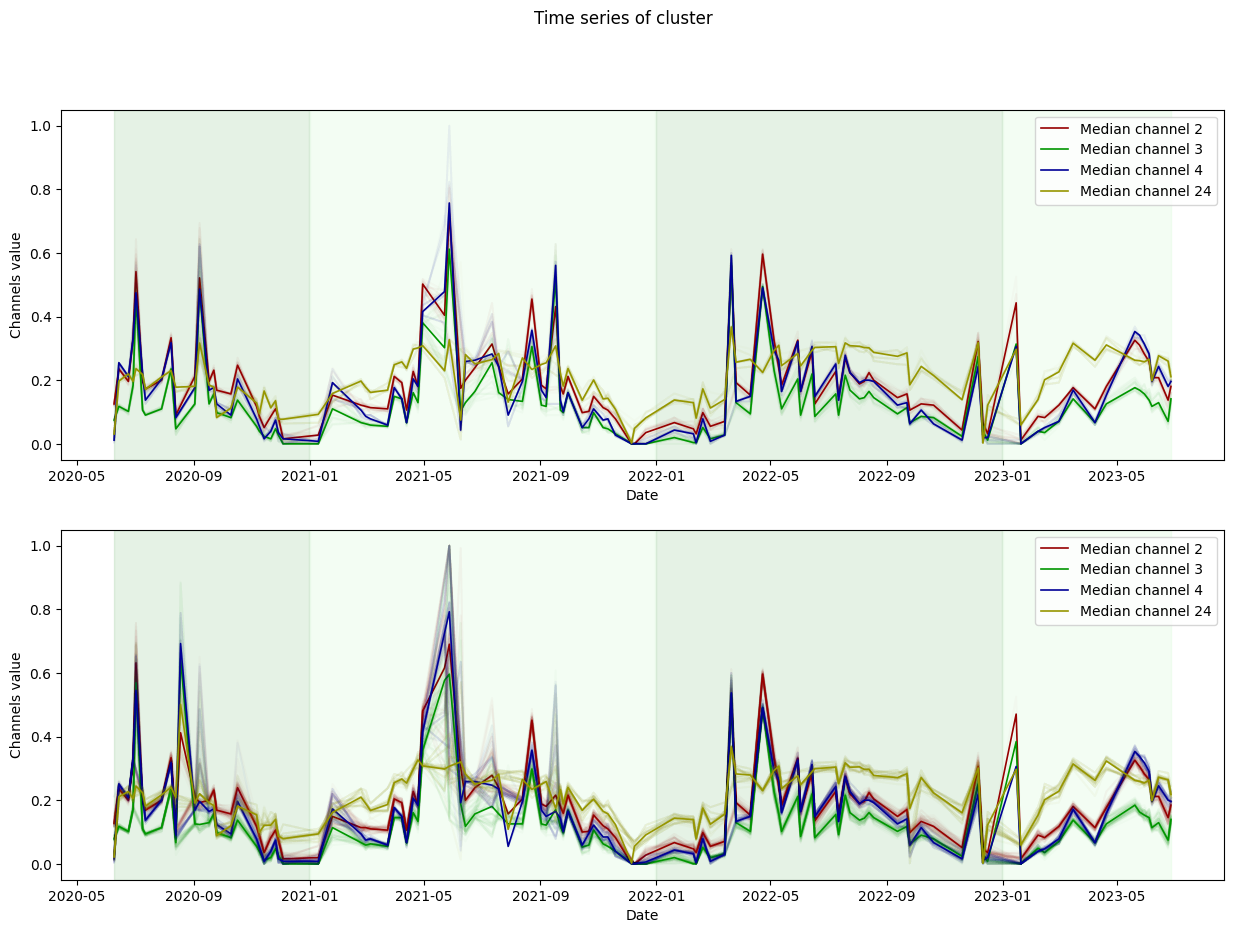

In [9]:
from goodforest_lib.models.clustering.fetch_data import get_historical_data_with_dates

historical_data, dates = get_historical_data_with_dates(images, dates, list(range(25)))
historical_data = historical_data.transpose(2, 3, 0, 1)
display_cluster_behavior(
    historical_data, dates, partition_zone, dates_clustering, (100, 245), [2, 3, 4, 24]
)

## Outlier detection


In [10]:
from goodforest_lib.models.clustering.anomaly_detection import predict_dieback

In [17]:
channels = [8, 24]

anomalies, anomalie_degrees, dates_detection = predict_dieback(
    images=images,
    dates=dates,
    clusters=partition_graph, # or partition_zone
    bands=channels,
    before_date="2023-01-01",
    detection_period_duration_in_days=30 * 4,
)

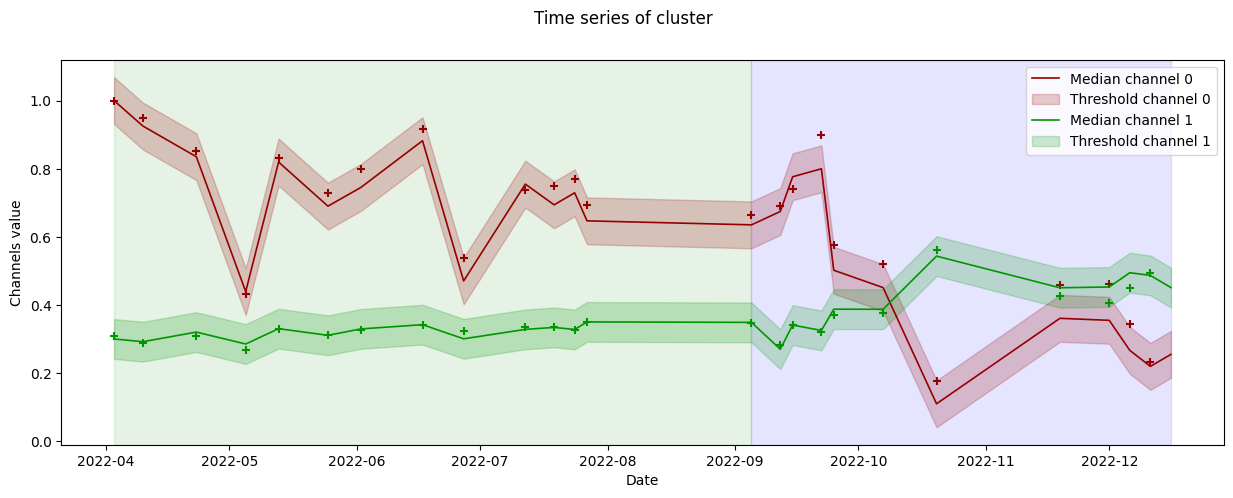

In [18]:
from goodforest_lib.visualization.visualize_clusters import display_outlying_px_behaviour

historical_data, dates = get_historical_data_with_dates(
    images, np.hstack([dates_clustering, dates_detection]), channels
)
historical_data = historical_data.transpose(2, 3, 0, 1)
display_outlying_px_behaviour(
    historical_data,
    dates_clustering,
    dates_detection,
    partition_graph, # or partition_zone
    anomalies[0][2],
    anomalies[0][0],
)